# Imports

In [1]:
import sys, os

import s3fs
import xarray as xr

import progressbar

import warnings

import rasterio

from math import sqrt
from joblib import Parallel, delayed

import numpy as np

from matplotlib import pyplot as plt
import imageio

sys.path.append('../utilities')
import GrIS_committedSLR_calibration_utilities as utils

import boto3

import pickle


import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

# Setup

In [18]:
start_year = 2007.
end_year = 2015.

grid_size = 50000.

grid_extent = np.array([-720500.0, 960500.0, -3450500.0, -569500.0])

dv_mod_obs_sigma_multiplier = 75.

debug_plots = True

start_year_string = '{:4d}'.format(int(start_year))[2:]
end_year_string   = '{:4d}'.format(int(end_year)  )[2:]

# For saving the results ...
run_name = 'velocity_sigmamodx{:.0f}'.format(dv_mod_obs_sigma_multiplier)
run_description = 'start_year = {:4.0f}; end_year = {:4.0f}; '.format(start_year, end_year) + \
                  'grid_size = {:8.0f}; residual_sigma_multiplier = {:5.0f};'.format(grid_size, dv_mod_obs_sigma_multiplier)


In [3]:
# Load total VAF / GMSL
vaf_cmmtt = dict()
vaf_ctrl = dict()
gmsl_anomaly_change_2100 = dict()

#vaf_files = [fn.replace('thickness','VAF',) for fn in cmmtt_files]
s3 = s3fs.S3FileSystem(anon=False)
vaf_files = s3.glob('dh-gapc/GrIS_committed_SLR/netcdfs/VAF/*cmmtt*VAF.nc')

for iFile, vaf_file in enumerate(vaf_files):
    ensembleID = os.path.basename(vaf_file).split('.')[3]
    
    # Read cmmtt VAF netcdf
    with s3.open(vaf_file, 'rb') as f:
        vaf_ds = xr.open_dataset(f, engine='h5netcdf')

        limnsw = vaf_ds['limnsw'].data
        vaf_cmmtt[ensembleID] = limnsw
    
    
    # Read ctrl VAF netcdf
    vaf_file = vaf_file.replace('cmmtt','ctrl')
    
    with s3.open(vaf_file, 'rb') as f:
        vaf_ds = xr.open_dataset(f, engine='h5netcdf')

        limnsw = vaf_ds['limnsw'].data
        vaf_ctrl[ensembleID] = limnsw
    
    
    vaf_anomaly = vaf_cmmtt[ensembleID] - vaf_ctrl[ensembleID]
    vaf_anomaly_change_2100 = vaf_anomaly[-1] - vaf_anomaly[0]
    gmsl_anomaly_change_2100[ensembleID] = -(vaf_anomaly_change_2100/1e12)/361.8


# Read velocity observations

In [4]:
_, _, vel_year1, _, _, vel_error_year1, vel_year1_transform, vel_year1_bounds = utils.read_vel_error_tifs(start_year)
_, _, vel_year2, _, _, vel_error_year2, vel_year2_transform, vel_year2_bounds = utils.read_vel_error_tifs(end_year)


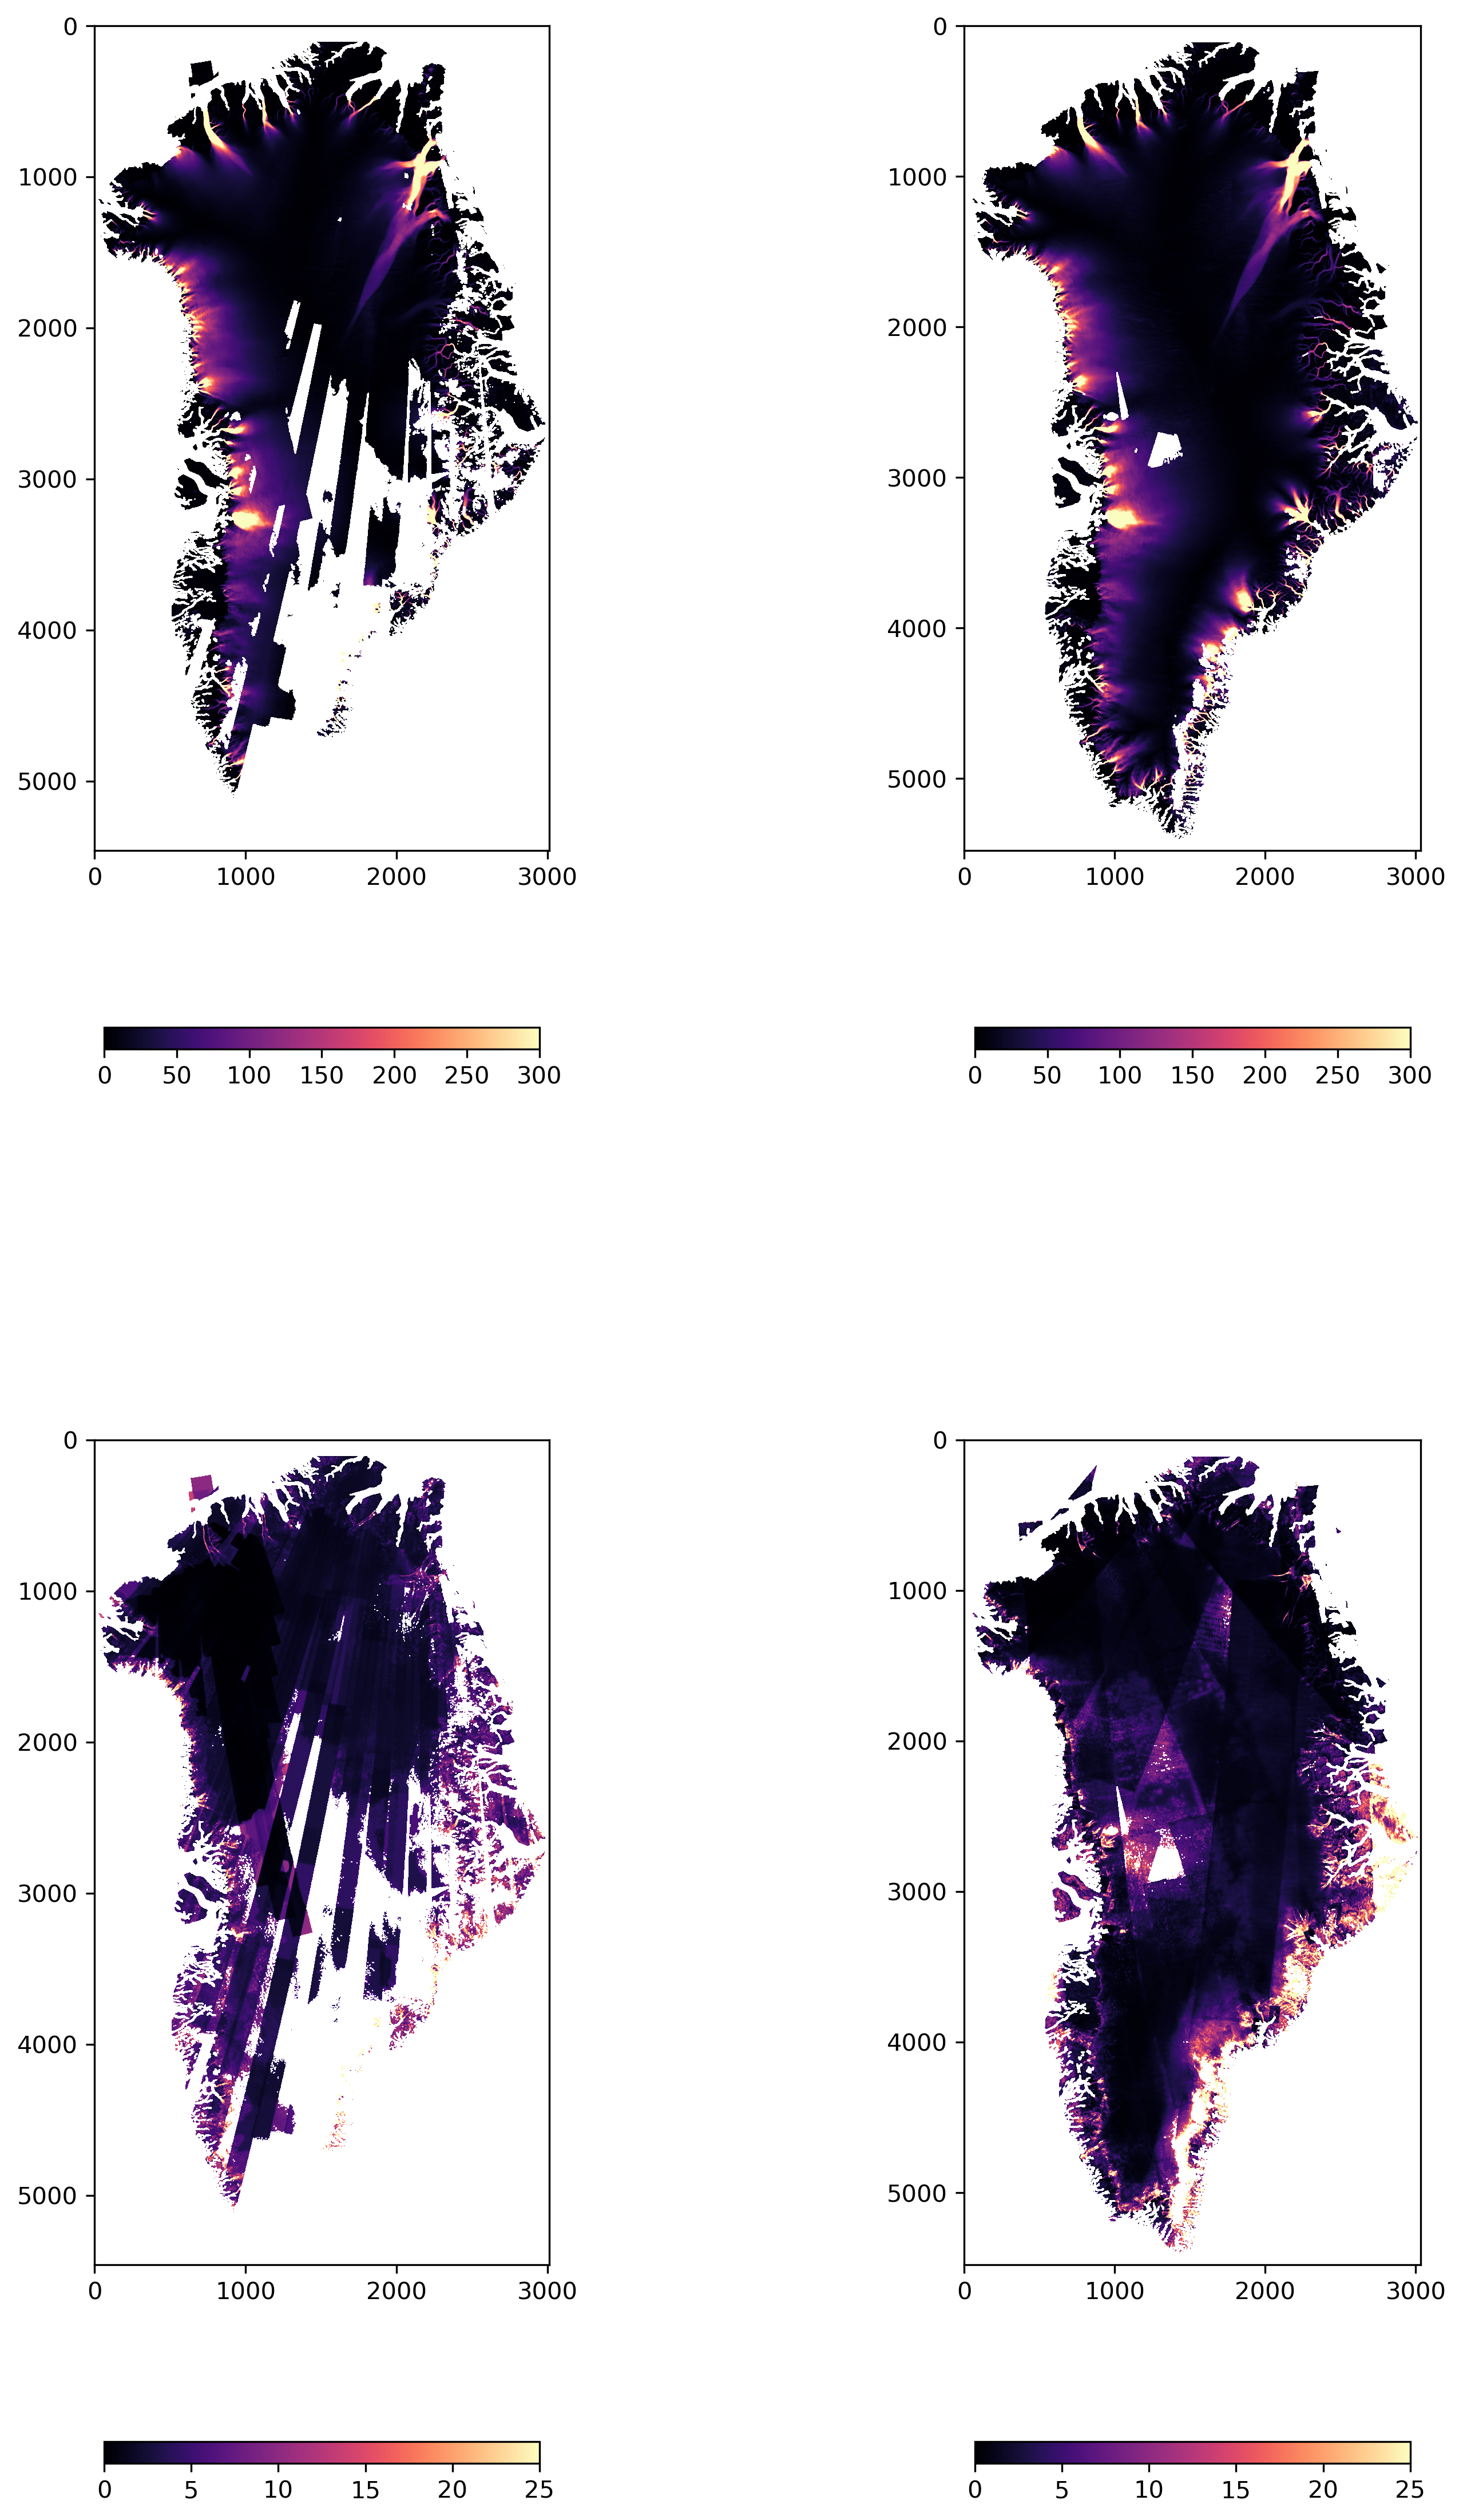

In [5]:
# Plot
fig, ax = plt.subplots(2,2,figsize=(12,20),dpi=300)
im0 = ax[0,0].imshow(vel_year1, cmap='magma', vmin=0, vmax=300)
im1 = ax[1,0].imshow(vel_error_year1, cmap='magma', vmin=0, vmax=25)
im2 = ax[0,1].imshow(vel_year2, cmap='magma', vmin=0, vmax=300)
im3 = ax[1,1].imshow(vel_error_year2, cmap='magma', vmin=0, vmax=25)
fig.colorbar(im0, ax=ax[0,0], orientation='horizontal', shrink=0.6)
fig.colorbar(im1, ax=ax[1,0], orientation='horizontal', shrink=0.6)
fig.colorbar(im2, ax=ax[0,1], orientation='horizontal', shrink=0.6)
fig.colorbar(im3, ax=ax[1,1], orientation='horizontal', shrink=0.6)

fig.savefig('plots/vel_obs_{:4.0f}_{:4.0f}.png'.format(start_year, end_year), bbox_inches='tight')


## Grid the observations

In [6]:
# Setup grid
x_centers = np.arange(grid_extent[0]+grid_size/2, grid_extent[1]-grid_size/2, grid_size)
y_centers = np.arange(grid_extent[2]+grid_size/2, grid_extent[3]-grid_size/2, grid_size)

if False:
    vel_min = 1000
    mask = vel_year1 < vel_min
    vel_year1[mask] = np.nan
    vel_error_year1[mask] = np.nan
    mask = vel_year2 < vel_min
    vel_year2[mask] = np.nan
    vel_error_year2[mask] = np.nan

vel_year1_obs_grid = utils.grid_vel_obs(vel_year1, vel_year1_transform, x_centers, y_centers, grid_size, grid_size)
vel_error_year1_obs_grid = utils.grid_vel_obs(vel_error_year1, vel_year1_transform, x_centers, y_centers, grid_size, grid_size)
vel_year2_obs_grid = utils.grid_vel_obs(vel_year2, vel_year2_transform, x_centers, y_centers, grid_size, grid_size)
vel_error_year2_obs_grid = utils.grid_vel_obs(vel_error_year2, vel_year2_transform, x_centers, y_centers, grid_size, grid_size)

dv_obs_grid = vel_year2_obs_grid - vel_year1_obs_grid
ev_obs_grid = np.sqrt(vel_error_year1_obs_grid**2 + vel_error_year2_obs_grid**2)


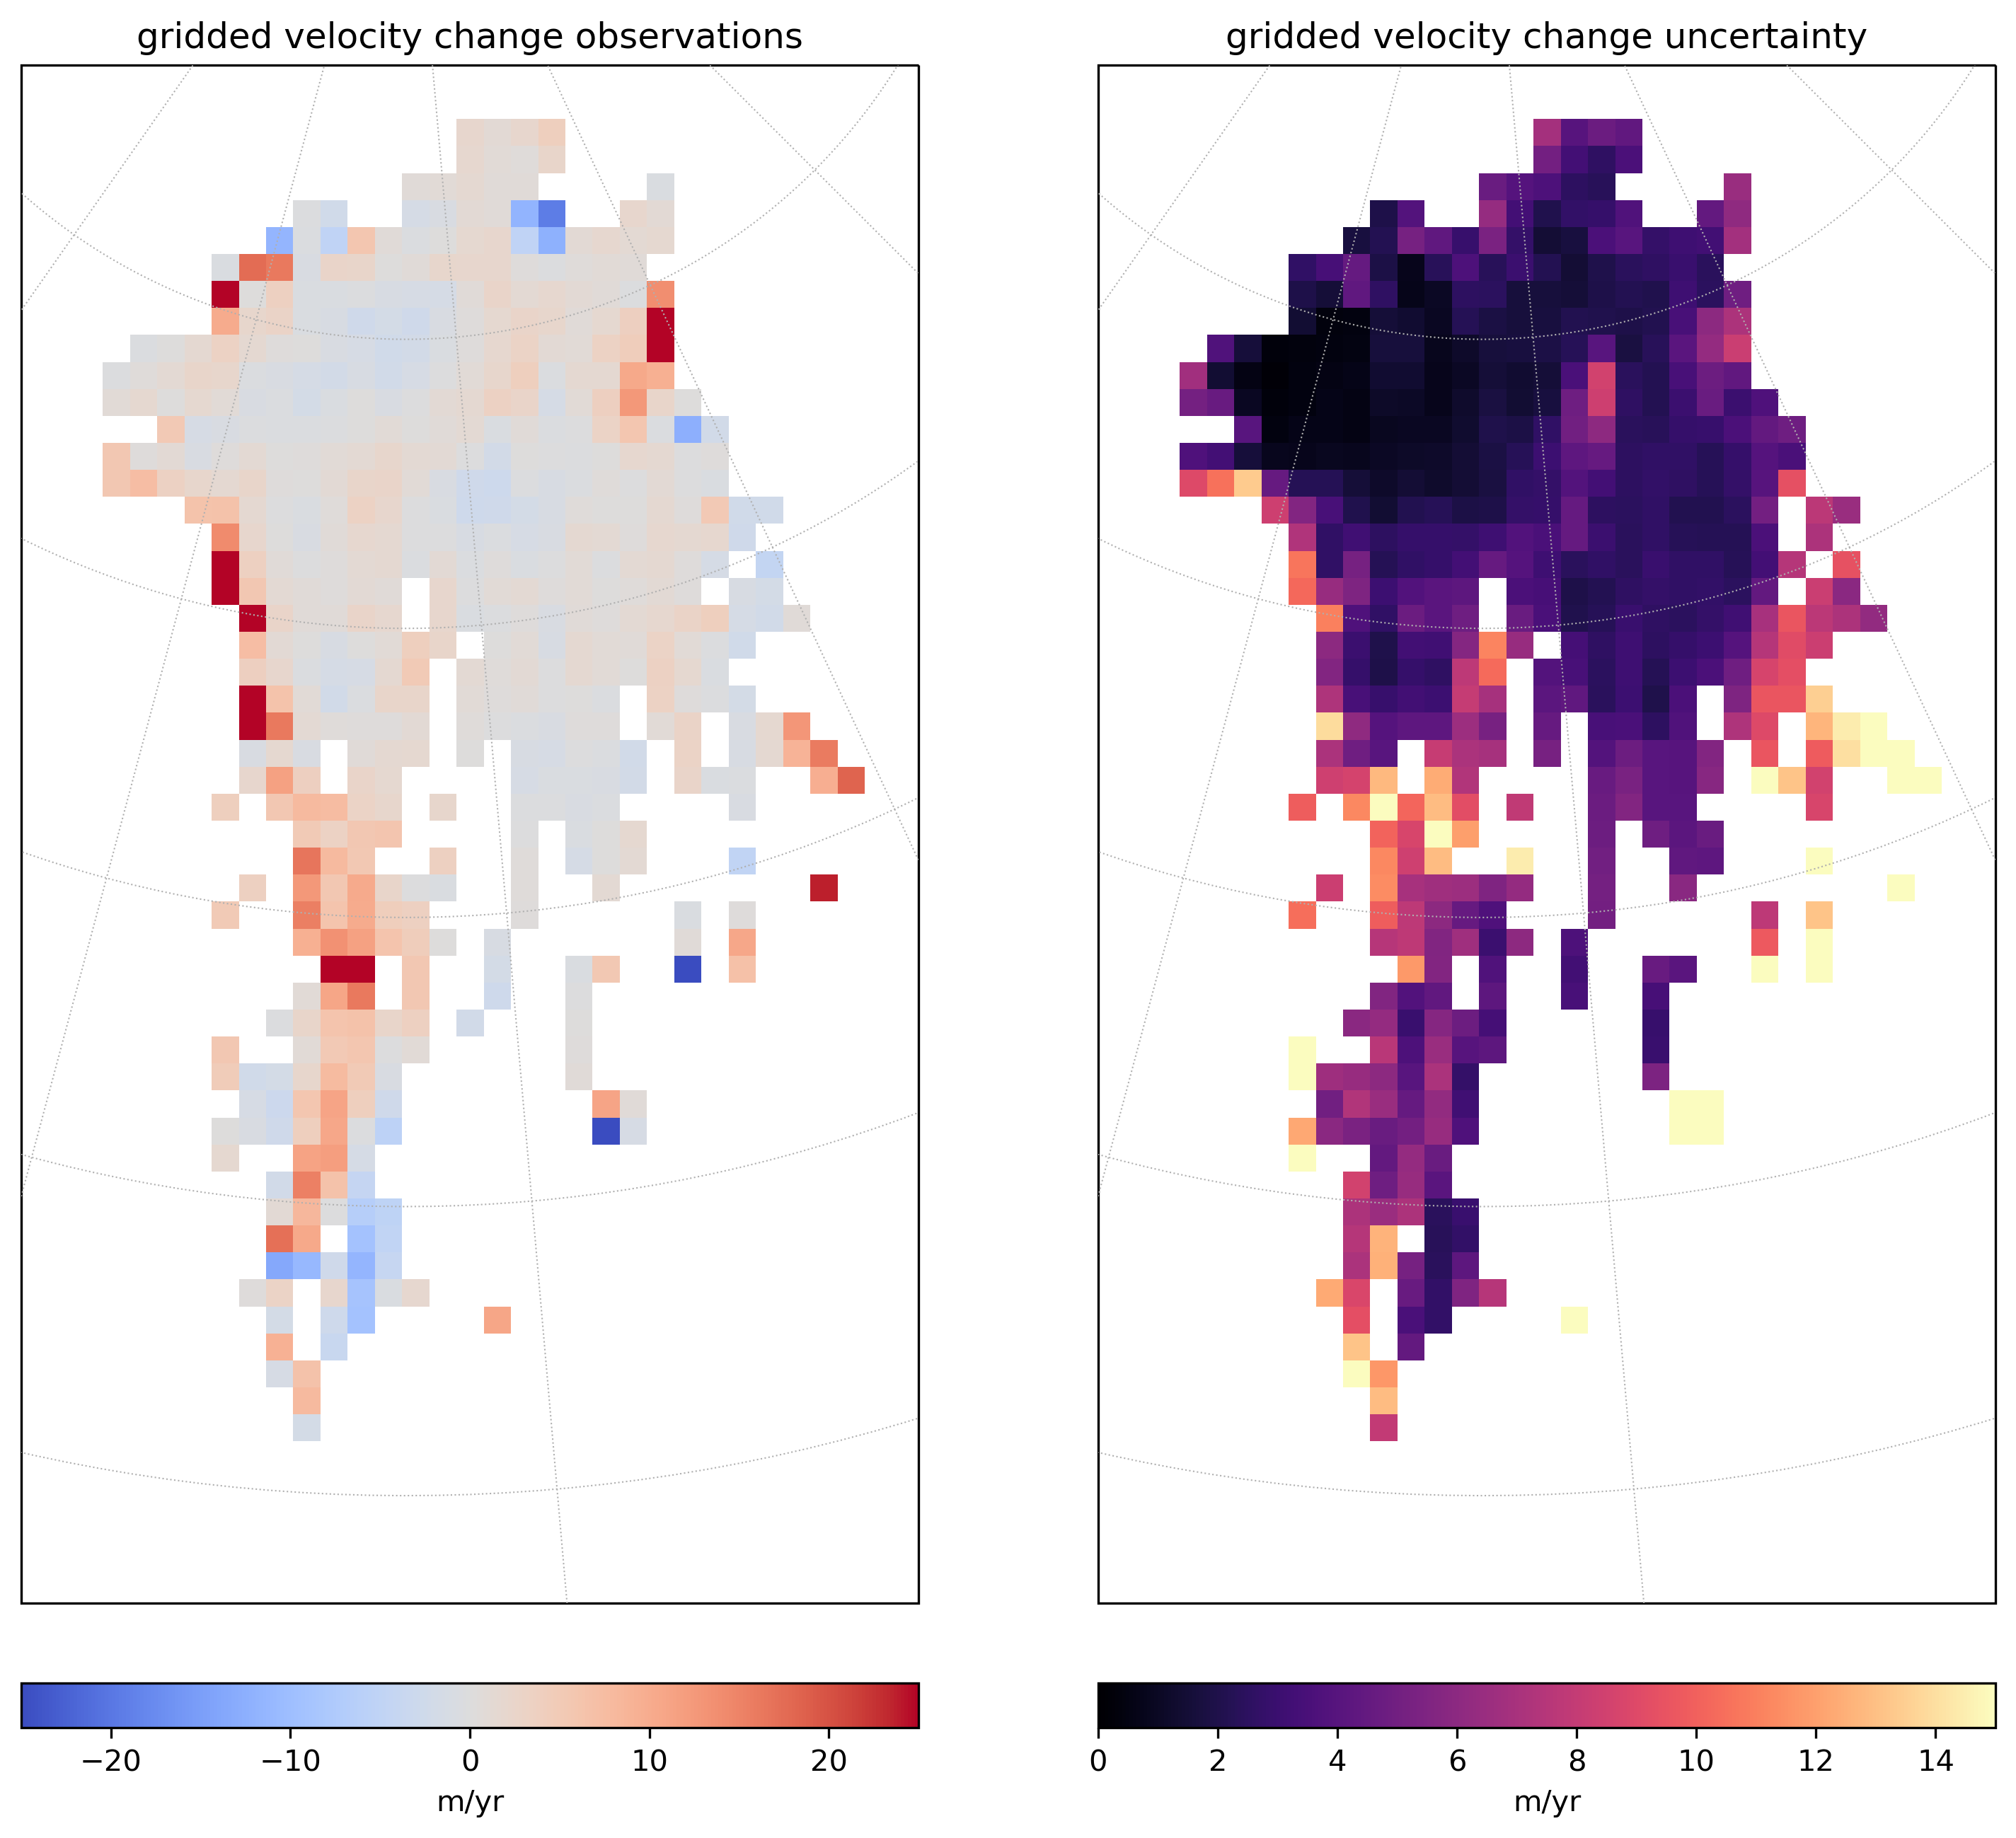

In [7]:
# Plot
if False:
    fig, ax = plt.subplots(2,3,figsize=(16,20),dpi=300)

    im0 = ax[0,0].imshow(vel_year1_obs_grid, cmap='magma',    vmin=0,    vmax=300, extent=grid_extent/1000., origin='lower')
    im1 = ax[0,1].imshow(vel_year2_obs_grid, cmap='magma',    vmin=0,    vmax=300, extent=grid_extent/1000., origin='lower')
    im2 = ax[0,2].imshow(dv_obs_grid,        cmap='coolwarm', vmin=-100, vmax=100, extent=grid_extent/1000., origin='lower')

    im3 = ax[1,0].imshow(vel_error_year1_obs_grid, cmap='magma',    vmin=0, vmax=25, extent=grid_extent/1000., origin='lower')
    im4 = ax[1,1].imshow(vel_error_year2_obs_grid, cmap='magma',    vmin=0, vmax=25, extent=grid_extent/1000., origin='lower')
    im5 = ax[1,2].imshow(ev_obs_grid,              cmap='magma',    vmin=0, vmax=25, extent=grid_extent/1000., origin='lower')

    fig.colorbar(im0, ax=ax[0,0], orientation='horizontal')
    fig.colorbar(im1, ax=ax[0,1], orientation='horizontal')
    fig.colorbar(im2, ax=ax[0,2], orientation='horizontal')

    fig.colorbar(im3, ax=ax[1,0], orientation='horizontal')
    fig.colorbar(im4, ax=ax[1,1], orientation='horizontal')
    fig.colorbar(im5, ax=ax[1,2], orientation='horizontal')

    ax[0,0].set_title('velocity - {:4.0f}'.format(start_year))
    ax[0,1].set_title('velocity - {:4.0f}'.format(end_year))
    ax[0,2].set_title('velocity - differece')

    ax[1,0].set_title('error - {:4.0f}'.format(start_year))
    ax[1,1].set_title('error - {:4.0f}'.format(end_year))
    ax[1,2].set_title('error - difference')

    

import cartopy.crs as ccrs
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)


# Plot just the velocity differences
fig, ax = plt.subplots(1,2,figsize=(12,20),dpi=300, subplot_kw={'projection': polar_stereographic})
im0 = ax[0].imshow(dv_obs_grid, cmap='coolwarm', vmin=-25, vmax=25, extent=grid_extent/1000., origin='lower')
im1 = ax[1].imshow(ev_obs_grid, cmap='magma',    vmin=0, vmax=15, extent=grid_extent/1000., origin='lower')
cb0 = fig.colorbar(im0, ax=ax[0], orientation='horizontal', pad=0.025)
cb1 = fig.colorbar(im1, ax=ax[1], orientation='horizontal', pad=0.025)

ax[0].coastlines() #resolution='10m', zorder=100, linewidth=10)
ax[0].gridlines(zorder=8, linestyle=':', linewidth=0.5) #, draw_labels=True)
ax[1].coastlines(resolution='10m', zorder=100, linewidth=0.5)
ax[1].gridlines(zorder=8, linestyle=':', linewidth=0.5)

cb0.ax.set_xlabel('m/yr')
cb1.ax.set_xlabel('m/yr')
ax[0].set_title('gridded velocity change observations')
ax[1].set_title('gridded velocity change uncertainty')

plt.savefig('plots/vel_obs_gridded_{:4.0f}_{:4.0f}.png'.format(start_year,end_year), bbox_inches='tight')


# Calculate residuals

<h3><font color='red'>NOTE:</font></h3> This can take a few minutes to run ...

In [19]:
import importlib
importlib.reload(utils)

# Find all model files
s3 = s3fs.S3FileSystem(anon=False)
s3.clear_instance_cache()
names = s3.glob('dh-gapc/GrIS_committed_SLR/zarr/velocity/*.nc.zarr')

# DEBUG
#names = names[:4]

# Loop through model files and return statistics and scores
with tqdm_joblib(tqdm(desc='Looping through models', total=len(names))) as progress_bar:
    results = Parallel(n_jobs=4)(delayed(utils.grid_models_and_calculate_residuals) \
                                (name, x_centers, y_centers, grid_size, \
                                 dv_obs_grid, ev_obs_grid, dv_mod_obs_sigma_multiplier, var_name='dv') for name in names)


s_j = np.array([r[0] for r in results])
w_j = s_j / np.sum(s_j)


Looping through models: 100%|██████████| 137/137 [01:23<00:00,  1.63it/s]


### Intermediate checks

(array([115.,  22.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98]),
 <BarContainer object of 49 artists>)

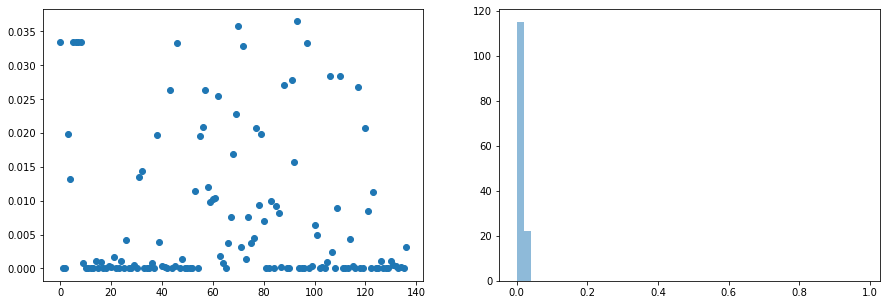

In [20]:
bins = np.arange(0,1.0,0.02)

# Plot the values of the weights
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(w_j, 'o', label='velocity weights')
ax[1].hist(w_j, bins=bins, alpha=0.5, label='velocity weights')

## Plot highest/lowest weighted ensemble members from velocity calibration

../utilities/GrIS_committedSLR_calibration_utilities.py:247: RuntimeWarning: Mean of empty slice
  z_mod_grid[row, col] = np.nanmean(z_mod[np.min(idx_row):np.max(idx_row), \


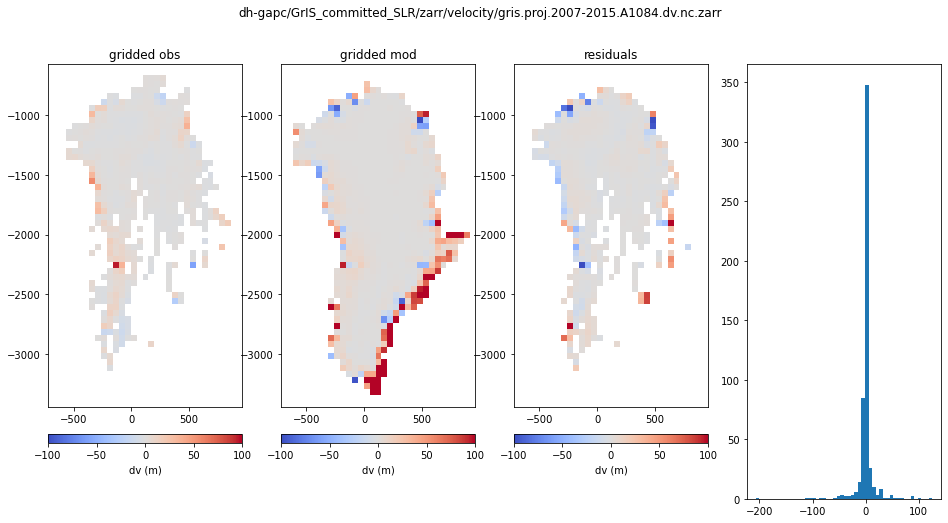

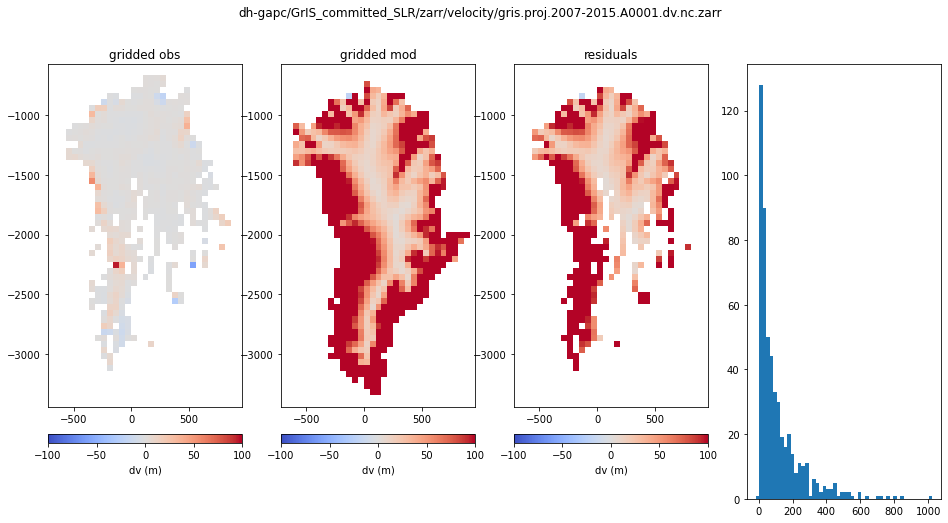

In [11]:
# Plot the observations with the ensemble members with the highest and lowest weights
w_j_sorted_idx = sorted(range(len(w_j)), key=lambda i: w_j[i])
name_highest_weight = names[w_j_sorted_idx[-1]]
name_lowest_weight  = names[w_j_sorted_idx[ 0]]


for mod_name in (name_highest_weight, name_lowest_weight):
    dv_mod_grid = utils.grid_mod_dh \
                                (mod_name, x_centers, y_centers, grid_size, grid_size, var_name='dv')


    fig, ax = plt.subplots(1,4,figsize=(16,8))

    im_dv = ax[0].imshow(dv_obs_grid, extent=[e/1000. for e in grid_extent], \
                   cmap='coolwarm', vmin=-100, vmax=100, origin='lower', \
                   aspect='auto')

    im_dv = ax[1].imshow(dv_mod_grid, extent=[e/1000. for e in grid_extent], \
                   cmap='coolwarm', vmin=-100, vmax=100, origin='lower', \
                   aspect='auto')

    residuals = dv_mod_grid - dv_obs_grid
    im_dv = ax[2].imshow(residuals, extent=[e/1000. for e in grid_extent], \
                   cmap='coolwarm', vmin=-100, vmax=100, origin='lower', \
                   aspect='auto')

    cb = plt.colorbar(im_dv, orientation='horizontal', ax=ax[0], pad=0.06)
    cb.set_label('dv (m)')
    cb = plt.colorbar(im_dv, orientation='horizontal', ax=ax[1], pad=0.06)
    cb.set_label('dv (m)')
    cb = plt.colorbar(im_dv, orientation='horizontal', ax=ax[2], pad=0.06)
    cb.set_label('dv (m)')

    residuals = residuals.flatten()
    residuals = residuals[~np.isnan(residuals)]
    ax[3].hist(residuals, bins=50)

    fig.suptitle(mod_name)
    ax[0].set_title('gridded obs')
    ax[1].set_title('gridded mod')
    ax[2].set_title('residuals')


# Save the weights

In [21]:
# Save the weights
if os.path.isdir('results/' + run_name):
    print('WARNING: Results directory with name ' + run_name + ' already exists!')

else:
    print('Saving ' + run_name)
    os.mkdir('results/' + run_name)

    txt_file = open('results/' + run_name + '/description.txt', 'w')
    txt_file.write(run_description)
    txt_file.close()

    pickle.dump({'s_j': s_j, 'w_j': w_j}, open('results/' + run_name + '/weights.p', 'wb'))
    

Saving velocity_sigmamodx75


# Bayesian calibration

In [ ]:
# Select the weights
run_names = [run_name]

w_j_list = list()
for run_name in run_names:
    p = pickle.load(open('results/' + run_name + '/weights.p', 'rb'))
    w_j = p['w_j']
    w_j_list.append(w_j)
    

In [ ]:
# Select thesholds
gmsl_thresholds = [8] # mm of GMSL rise in 2100


gmsl_anomaly_change_2100_values = list(gmsl_anomaly_change_2100.values())

bins = np.arange(0,16,1)

fig, ax = plt.subplots(figsize=(8,6))

# estimated density: prior
_ = ax.hist(gmsl_anomaly_change_2100_values, density=True, alpha=0.2, bins=bins)

for run_name, w_j in zip(run_names, w_j_list):
    # SERAC weights
    x_kpde, gmsl_prior, gmsl_posterior = utils.gmsl_prior_posterior(gmsl_anomaly_change_2100_values, w_j)

    # estimated density: posterior (SERAC)
    ax.plot(x_kpde, gmsl_posterior, label='posterior ' + run_name, linewidth=2.)

ax.plot(x_kpde, gmsl_prior, label='prior', color='b', linewidth=1.)

plt.legend()
plt.xlabel('GMSL in 2100')
plt.ylabel('probability')
